## EDA Project


### The Tasks

* Through EDA/statistical analysis above please come up with AT LEAST 3 insights regarding the overall data. One should be geographical.

* In addition also come up with AT LEAST 3 recommendations for your client.

* Note, you can take either the perspective of a buyer or a seller. Choose a client from the list at the end of this file.

### The Deliverables

* New repository from template
* A well documented Jupyter Notebook (see here for an example) containing  the code you've written for this project and comments explaining it. This work will need to be pushed to your GitHub repository in order to submit your project. Do not push all the analysis... just the analysis that is relevant! You can start with the starter notebook.
* An updated and organized README.md file in the GitHub repository that describes the contents of the repository. This file should be the source of information for navigating through the repository.
* A short Keynote/PowerPoint/Google Slides/Jupyter slides presentation giving a high-level overview of your methodology and recommendations for non-technical clients. The duration of the presentation should be 10 minutes, then the discussion will continue for 5 minutes. Also put your slides (delivered as a PDF export) on Github to get a well-rounded project. Do not present using your jupyter notebook!
* Optional - A Python script for processing and cleaning your data, here feel free to write clean code, using functions and docstrings. Even more optional you can also do unit tests. If you do this part, you may also update your EDA notebook to make use of these functions. See (optional)[optional] folder for example.


### Client

Amy Williams:

* Seller
* Italian mafiosi
* Sells several central houses(top10%) over time
* needs average outskirt houses over time to hide from the FBI

## Import

In [ ]:
# Import of Libraries 

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
from dotenv import load_dotenv
import missingno as msno
import math 
import plotly.express as px
from geopy.distance import geodesic
from matplotlib.ticker import PercentFormatter
import plotly.graph_objs as go

plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
#Import of Data via SQL

load_dotenv()

#get credential from .env file
DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

# Create connection object conn
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)
# fetch data
cur = conn.cursor()
sql_query_fetch_all_data = """
    SELECT *
    FROM eda.king_county_house_details
    JOIN eda.king_county_house_sales
    ON eda.king_county_house_details.id = eda.king_county_house_sales.house_id;
"""
cur.execute(sql_query_fetch_all_data)
cur.fetchall()
df_all = pd.read_sql(sql_query_fetch_all_data, conn)

# close the connection
conn.close()

# export to csv
df_all.to_csv('merged_data.csv',index=False)

In [ ]:
# read working table into the dataframe
df_joined_table = pd.read_csv('merged_data.csv')
df_joined_table

#check of columns of SQL Table and CSV table are the same
df_all.columns == df_joined_table.columns

## Data Cleanup

In [ ]:
# check how many duplicated rows exist in the data frame
df_joined_table.duplicated().value_counts()

#--> No duplicates were found

In [ ]:
#Check for NaN in the Table
df_joined_table.isna().sum()

In [ ]:
#Visualisation of missing data via msno
msno.matrix(df_joined_table)

In [ ]:
df_joined_table.dtypes


data types mostly look good except:

* waterfront is float64 should be bool 

* view is float64 should be bool !

* yr_renovated is float64 should be int

* date is object should be date (year, month, day)

* price is float, is ok but could be int; no one cares about pennies in these dimensions

In [ ]:
#function for yr_renovated column to convert to Integer and 'XXXX' format
def conv_float_to_date(flt_val):
    '''
    convert float to int for df_joined_table['yr_renovated']
    '''
    if math.isnan(flt_val):
        return flt_val
    elif isinstance(flt_val, float):
        # Convert float to int and then to a string
        flt_val = int(flt_val)
        # Extract the year part from the string
        flt_val = int(str(flt_val)[:4])
        return flt_val

In [ ]:
# conversion a mentioned above
# Bool type values: waterfront, view
df_joined_table['waterfront'] = df_joined_table['waterfront'].replace(np.NaN,0)
df_joined_table['waterfront'] = df_joined_table['waterfront'].apply(lambda value: bool(value))

# date type objects: yr_built, yr_renovated, date
df_joined_table['date'] = pd.to_datetime(df_joined_table['date'], format='%Y-%m-%d')

# replace 0 by NaN
df_joined_table['yr_renovated'] = df_joined_table['yr_renovated'].replace(np.nan, 0)
df_joined_table['sqft_basement'] = df_joined_table['sqft_basement'].replace(0,np.NaN)

# Apply the conversion function to the 'yr_renovated' column
df_joined_table['yr_renovated'] = df_joined_table['yr_renovated'].apply(conv_float_to_date)
# Ensure the 'yr_renovated' column is of integer data type
df_joined_table['yr_renovated'] = df_joined_table['yr_renovated'].astype(int)

# Int type values: sqft_living, sqft_lot, sqft_living,  sqft_lot, floorssqft_lot15, sqft_living15, price
df_joined_table['view'] = df_joined_table['view'].replace(np.NaN,0)
int_cov_lst = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_living', 'sqft_lot', 'floors', 'sqft_lot15', 'sqft_living15', 'price', 'view']

for colnam in int_cov_lst: 
    df_joined_table[colnam] = df_joined_table[colnam].apply(lambda value: int(value))

df_joined_table.dtypes

In [ ]:
# Assumming that if Basement = NaN --> No Basement is present
msno.matrix(df_joined_table)

## Three Overall Data Insights

In [ ]:
#To grasp overall correlation, create a correlation matrix as heat map
corr_matrix = df_joined_table.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.grid(visible=False)
plt.show()

In [ ]:
#Plot Bar/Price
grades = df_joined_table['grade']
prices = df_joined_table['price']

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(grades, prices)
plt.xlabel('Grade')
plt.ylabel('Price [K$]')
plt.title('Grade vs Price')
plt.show()

In [ ]:
#Plot yr_built/price
yr_built = df_joined_table['yr_built'].sort_values()
prices = df_joined_table['price']

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(yr_built, prices)
plt.xlabel('yr_built')
plt.ylabel('Price [K$]')
plt.title('yr_built vs Price')
plt.show()

In [ ]:
# Plot the frequency of houses getting built or renovated over the years
# rename Data for plots
data1 = df_joined_table['yr_renovated']
data2 = df_joined_table['yr_built']

# Filter out the 0 values for both datasets
filtered_data1 = data1[data1 != 0]
filtered_data2 = data2[data2 != 0]

# Create a histogram
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the first histogram (Years Renovated)
pl1 = ax.hist(filtered_data1, bins=27, color='red', alpha=0.5, label='Years Renovated')

# Set the common x-axis label and title
ax.set_xlabel('Years')
ax.set_title('Histogram of Years Renovated and Years Built (Excluding 0)')

# Create a second y-axis on the right for the second histogram
ax2 = ax.twinx()

# Plot the second histogram (Years Built)
pl2 = ax2.hist(filtered_data2, bins=27, color='blue', alpha=0.5, label='Years Built')

# Set the second y-axis label
ax2.set_ylabel('Frequency (Years Built)')
ax.set_ylabel('Frequency (Years Renovated)')

# Combine the legends from both histograms
handles, labels = [], []
for ax in [ax, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

plt.legend(handles, labels, loc='upper left', frameon=False)

plt.show()



## Three Recommendations for the Client Amy Williams

In [ ]:
# create a new df, grouped by zip code an mean of lat long for each zip with cols: Lat, Long, Zip 
# ==> Shows 'centers' for each zip code
df_zip_grouped = df_joined_table.groupby('zipcode')

df_zip_mean = df_zip_grouped[['lat','long','grade']].mean()

df_zip_mean = df_zip_mean.reset_index()

In [ ]:
#group by zipcode and count the entrys of houses, to have houses per zipcode
df_zip_grouped_density = df_joined_table.groupby('zipcode')

df_zip_grouped_density_counts = df_zip_grouped_density['zipcode'].value_counts()
df_zip_grouped_density_counts = df_zip_grouped_density_counts.reset_index()
df_zip_grouped_density_counts.head(10)

#Merge the center of the zip codes with the table of house densities
df_Zip_long_lat_count = df_zip_mean.merge(df_zip_grouped_density_counts)
df_Zip_long_lat_count.head(10)

#plot a density map
fig_mean_zip = px.scatter_mapbox(df_Zip_long_lat_count,
                                 lat='lat',
                                 lon='long',
                                 hover_name='zipcode',
                                 size='count',
                                 color='count',  # Updated this line to color points by density
                                 color_continuous_scale=px.colors.sequential.Plasma,  # Added a color scale
                                 zoom=10,
                                 height=600)

# Mapbox
fig_mean_zip.update_layout(mapbox_style="open-street-map")
fig_mean_zip.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_mean_zip.show()

In [ ]:
# Assumption:
# Filter the density list for counts under 200 -> Less populated area

df_Zip_long_lat_count_filtered = df_Zip_long_lat_count.query('count < 200')
   
#plot a density map
fig_mean_zip = px.scatter_mapbox(df_Zip_long_lat_count_filtered,
                                 lat='lat',
                                 lon='long',
                                 hover_name='zipcode',
                                 size='count',
                                 color='count',  # Updated this line to color points by density
                                 color_continuous_scale=px.colors.sequential.Plasma,  # Added a color scale
                                 zoom=10,
                                 height=600)

# Mapbox
fig_mean_zip.update_layout(mapbox_style="open-street-map")
fig_mean_zip.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_mean_zip.show()

#### Having looked at the map, we see that the following zip codes are in the outskirts and have a low house density: 

- 98011
- 98077 
- 98019 
- 98014
- 98024 
- 98010
- 98002
- 98070



#### From these Zipcodes, Average Houses (Grade 7, Condition 3) were selected. Additionally, houses need to have a basement for mafiosi activities :)
#### Due to the frequency of location change, the cheapest houses were prefered (Sort by Price)

Infos: 

* 7 - Average grade of construction and design. Commonly seen in plats and older sub-divisions.

* 3 - Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

 https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

In [ ]:

zip_lst = [98011, 98077, 98019, 98014, 98024, 98010, 98002, 98070]

df_raw_canidates = df_joined_table[df_joined_table['zipcode'].isin(zip_lst) ]
#maffiosi needs a basement
df_raw_canidates_with = df_raw_canidates[df_raw_canidates['sqft_basement'] >0 ]
#must be medium grade = average
df_canidates_average = df_raw_canidates_with.query('grade == 7 and condition == 3')

df_canidates_average =df_canidates_average.sort_values('price', ascending=True)

#get 3 canidates, lowest price 

df_final_canidates = df_canidates_average.head(3)
df_final_canidates

In [ ]:
#show top 3 cheapest choices of outskirt houses on Map

fig_mean_zip = px.scatter_mapbox(df_final_canidates,
                                 lat='lat',
                                 lon='long',
                                 hover_name='zipcode',
                                 zoom=10,
                                 height=600)


# Set your Mapbox access token here
fig_mean_zip.update_layout(mapbox_style="open-street-map")
fig_mean_zip.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_mean_zip.show()

#### Calculate the top 10% most central houses 

In [ ]:
#Assumption: Central Location of Seattle defined as:
# Geographic Coordinates:
# 47.608433126484584, -122.2970951858066

#Setting the center as variable
geographic_centroid_lat = 47.608433126484584, -122.2970951858066

#Function to calc the distance via lat, and long and output is kilometers
def dist_to_center (lat, long):
    '''
    Calculate distances from Centroid in KM
    Center set as:
    geographic_centroid_lat= 47.608433126484584,-122.2970951858066
    geographic_centroid_long= -122.2970951858066
    '''
    gc= (47.60843312648, -122.297095185)
    target = (lat, long)
    distance = geodesic(gc, target).kilometers
    return distance

# Apply dist_to_center function to each row and save in "distance_to_ceter" column, ascending order
df_joined_table['distance_to_center'] = df_joined_table.apply(lambda row: dist_to_center(row['lat'], row['long']), axis=1)
df_joined_table_center = df_joined_table.sort_values('distance_to_center', ascending= True)

#Choose the top 10% closet houses to our set Location-Center
#Therefore, calc how much 10% of rows our DF is
df_rows = int(round(len(df_joined_table_center)*0.1))

#apply the number of rows we need to the table (which was sorted by distance to the center)
df_top_10_center = df_joined_table_center.head(df_rows)

df_top_10_center

In [ ]:
#Mapbox Plot for the top 10% most centric Houses
fig = px.scatter_mapbox(df_top_10_center, 
                        lat="lat",  # Latitude column
                        lon="long",  # Longitude column
                        hover_name="house_id",  # Display 'house_id' when hovering
                        zoom=10)  # Set the initial zoom level

# Customize the map layout and appearance
fig.update_layout(mapbox_style="open-street-map",
                  mapbox_zoom=10,
                  mapbox_center={"lat": 47.608433126484584, "lon": -122.2970951858066})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

df_centroid_lat = [47.608433126484584]
df_centroid_long = [-122.2970951858066]

# Add a City Center in red using go.Scattermapbox
fig.add_trace(go.Scattermapbox(lat=df_centroid_lat,
                               lon=df_centroid_long,
                               mode='markers',
                               marker=dict(size=10, color='red')))

fig.show()

In [ ]:
#price over time top 10% center
df_top_10_center['month'] = pd.to_datetime(df_top_10_center['date']).dt.month
df_top_10_center_month = df_top_10_center.groupby('month')
df_top_10_center_month_mean = df_top_10_center_month['price'].mean()
df_top_10_center_month_mean = df_top_10_center_month_mean.reset_index()
#-----------------------------------------------------------------------------
#All Houses
df_joined_table['month'] = pd.to_datetime(df_joined_table['date']).dt.month
df_joined_table_month = df_joined_table.groupby('month')
df_joined_table_month_mean = df_joined_table_month['price'].mean()
df_joined_table_month_mean = df_joined_table_month_mean.reset_index()
#-----------------------------------------------------------------------------
#Avg houses in outskirts
df_canidates_average['month'] = pd.to_datetime(df_canidates_average['date']).dt.month
df_canidates_average_month = df_canidates_average.groupby('month')
df_canidates_average_month_mean = df_canidates_average_month['price'].mean()
df_canidates_average_month_mean = df_canidates_average_month_mean.reset_index()
#setting variables for easy use
x = df_joined_table_month_mean['month']
# Plotting
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(x, df_canidates_average_month_mean['price'], label='Average Houses')
plt.plot(x, df_joined_table_month_mean['price'], label='All Houses')
plt.plot(x, df_top_10_center_month_mean['price'], label='Top 10 Houses')
# make it look nice
plt.xlabel('Month')
plt.ylabel('Price [$]')
plt.title('Price development over time')
plt.legend()
plt.xlim(1, 12)  # Set the x-axis limits from 0 to 12
x_ticks = range(1, 13)  # Values from 1 to 12
plt.xticks(x_ticks)
plt.ylim(300000, 900000)
# Display the plot
plt.grid(True)
plt.show()

## David Test

In [46]:
df_joined_table.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date', 'price', 'house_id',
       'distance_to_center', 'month'],
      dtype='object')

    grade  waterfront  average_cost_without_waterfront   
0       3       False                       262000.000  \
1       4       False                       212001.852   
2       5       False                       245965.971   
3       6       False                       300420.597   
4       7       False                       401528.895   
5       8       False                       538897.976   
6       9       False                       768803.298   
7      10       False                      1042090.441   
8      11       False                      1425734.629   
9      12       False                      2052594.937   
10     13       False                      3710769.231   

    average_cost_with_waterfront  
0                          0.000  
1                          0.000  
2                     400725.000  
3                     605300.000  
4                     856928.571  
5                    1313857.812  
6                    1355386.364  
7                    22

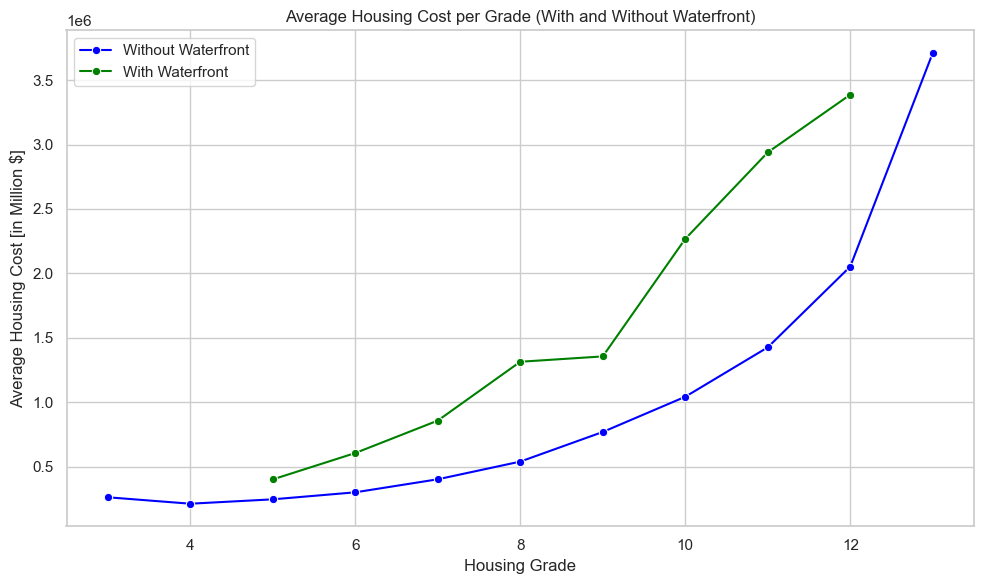

In [59]:
#Hypothesis Average Housing cost increases with waterview even if houses are in the same grade

# Assuming you have a DataFrame df_joined_table

# Group by 'grade' and 'waterfront', and calculate the mean price
average_cost_per_grade = df_joined_table.groupby(['grade', 'waterfront'])['price'].mean().reset_index()

# Filter the data to separate waterfront and non-waterfront averages
average_cost_without_waterfront = average_cost_per_grade[average_cost_per_grade['waterfront'] == 0]
average_cost_with_waterfront = average_cost_per_grade[average_cost_per_grade['waterfront'] == 1]

# Rename the 'price' column to indicate whether it's with or without waterfront
average_cost_without_waterfront.rename(columns={'price': 'average_cost_without_waterfront'}, inplace=True)
average_cost_with_waterfront.rename(columns={'price': 'average_cost_with_waterfront'}, inplace=True)

# Merge the two DataFrames to get both averages in one DataFrame
average_cost_per_grade = average_cost_without_waterfront.merge(
    average_cost_with_waterfront[['grade', 'average_cost_with_waterfront']],
    on='grade',
    how='outer'
)

# Fill any missing values with 0
average_cost_per_grade.fillna(0, inplace=True)

# Display the resulting DataFrame
print(average_cost_per_grade)


# Filter the DataFrame to exclude specific rows
filtered_data = average_cost_per_grade[
    ~((average_cost_per_grade['grade'].isin([3, 4]) & (average_cost_per_grade['waterfront'] == 1)) |
      (average_cost_per_grade['grade'] == 13) & (average_cost_per_grade['waterfront'] == 1))
]

# Set the style for the plot (optional)
sns.set_style("whitegrid")

# Create the line plot
plt.figure(figsize=(10, 6))

# Plot the line for "Without Waterfront"
sns.lineplot(
    data=filtered_data,
    x='grade',
    y='average_cost_without_waterfront',
    label='Without Waterfront',
    marker='o',  # Specify marker style (optional)
    color='blue'  # Specify the color for this line
)

# Plot the line for "With Waterfront" only for selected grades
sns.lineplot(
    data=filtered_data[~filtered_data['grade'].isin([3, 4, 13])],  # Exclude grades 3, 4, and 13
    x='grade',
    y='average_cost_with_waterfront',
    label='With Waterfront',
    marker='o',  # Specify marker style (optional)
    color='green'  # Specify the color for this line
)

# Customize the plot's appearance
plt.xlabel('Housing Grade')
plt.ylabel('Average Housing Cost [in Million $]')
plt.title('Average Housing Cost per Grade (With and Without Waterfront)')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


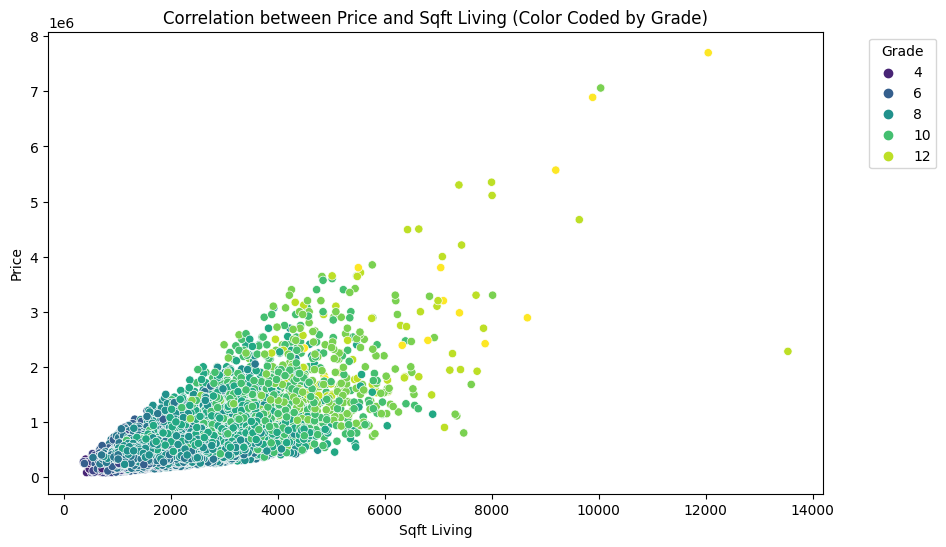

In [42]:
#Neighborhoods with higher wealth/q.o.l. (real estate grade and price) correlate with a larger living area and larger average neighborhood living areas

# Create a scatter plot with color-coded points based on "grade"
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_joined_table, x="sqft_living", y="price", hue="grade", palette="viridis")

# Customize the plot's appearance
plt.title("Correlation between Price and Sqft Living (Color Coded by Grade)")
plt.xlabel("Sqft Living")
plt.ylabel("Price")

# Show the legend
plt.legend(title="Grade", bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
##LÖSCHENe=????

zipcode_means = df_joined_table.groupby('zipcode')['price'].mean().reset_index()
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_joined_table['grade'], df_joined_table['price'], c=df_joined_table['zipcode'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='zipcode')
plt.xlabel('Grade')
plt.ylabel('Price')
plt.title('House Grade vs. Price by ZipCode')
plt.show()

In [ ]:
### LÖSCHEN?=???


import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# Assuming you have a DataFrame df_joined_table with columns 'grade', 'price', 'zipcode', 'lat', and 'long'

# Create a scatter map
fig = px.scatter_mapbox(
    df_joined_table,
    lat='lat',
    lon='long',
    color='grade',
    size='price',
    hover_name='zipcode',
    hover_data=['grade'],
    color_continuous_scale='Viridis',
    size_max=20,
    opacity=0.7,
    mapbox_style='open-street-map'  # Try a different map style
)

# Customize the map layout (optional)
fig.update_layout(
    mapbox=dict(
        center=dict(lat=df_joined_table['lat'].mean(), lon=df_joined_table['long'].mean()),
        zoom=10,
    ),
)

# Show the map
fig.update_layout(title='House Grade vs. Price by ZipCode')

fig.show()
